In [1]:
#!pip install opencv-python
#!pip install tqdm

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
from tqdm import tqdm_notebook
import pickle

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
# Пригодятся для сохранения переменных
def load_obj(name):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open('./data/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

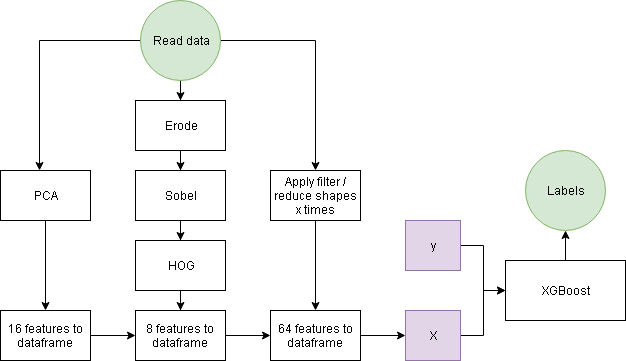

In [3]:
# Вот так будет выглядеть процесс обработки изображений и сбора фич
Image('./data/process.png')

### Read

In [4]:
# Читаем данные
train = np.loadtxt('./data/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/test.csv', delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

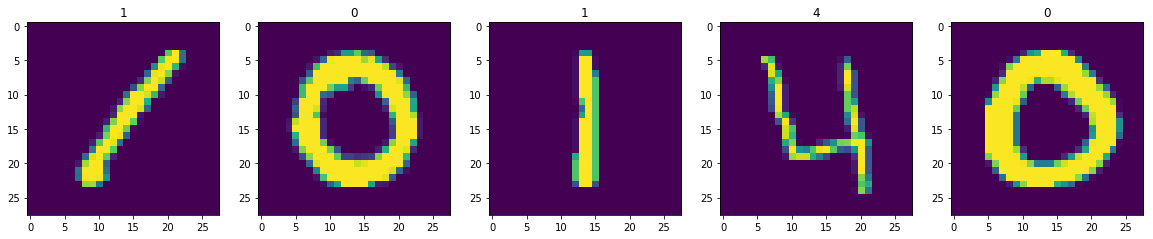

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(train_img[i])
    ax[i].set_title(int(train_label[i]))

### Erode

In [7]:
kernel = np.ones((2,2), np.uint8)

train_erode = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_erode[i] = cv2.erode(train_img[i], kernel, iterations = 1)

test_erode = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_erode[i] = cv2.erode(test_img[i], kernel, iterations = 1)

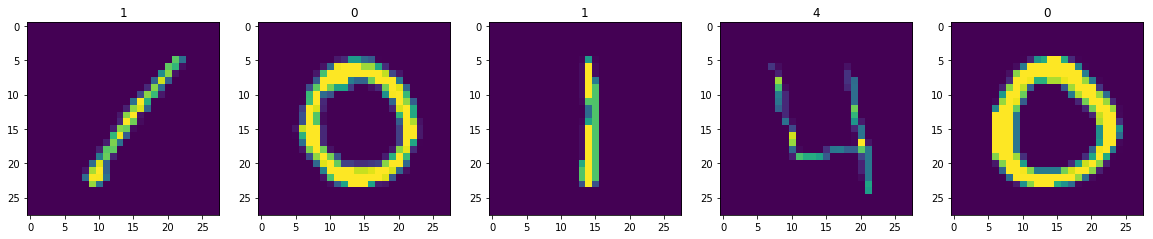

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(train_erode[i])
    ax[i].set_title(int(train_label[i]))

### Sobel

In [9]:
train_erode_sobel_x = np.zeros_like(train_erode)
train_erode_sobel_y = np.zeros_like(train_erode)
for i in range(len(train_erode)):
    train_erode_sobel_x[i] = cv2.Sobel(train_erode[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_erode_sobel_y[i] = cv2.Sobel(train_erode[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    
test_erode_sobel_x = np.zeros_like(test_erode)
test_erode_sobel_y = np.zeros_like(test_erode)
for i in range(len(test_erode)):
    test_erode_sobel_x[i] = cv2.Sobel(test_erode[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_erode_sobel_y[i] = cv2.Sobel(test_erode[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [10]:
train_erode_g, train_erode_theta = cv2.cartToPolar(train_erode_sobel_x, train_erode_sobel_y)
test_erode_g, test_erode_theta = cv2.cartToPolar(test_erode_sobel_x, test_erode_sobel_y)

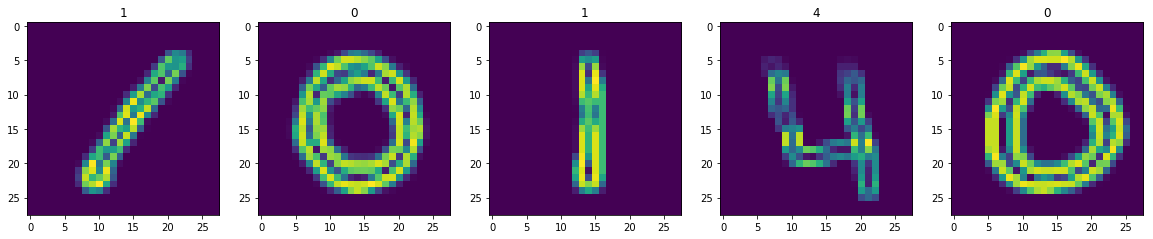

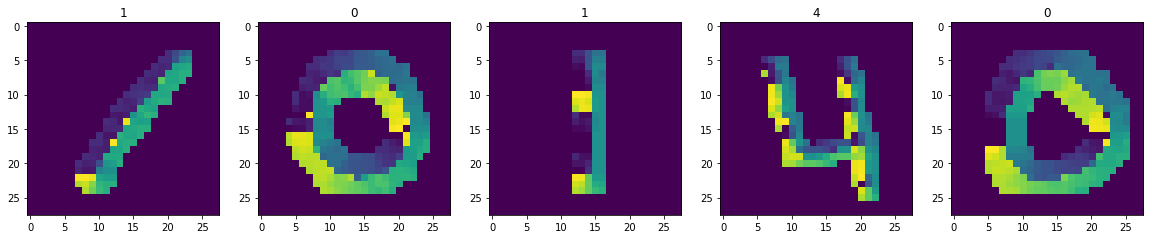

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(train_erode_g[i])
    ax[i].set_title(int(train_label[i]))
    
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(train_erode_theta[i])
    ax[i].set_title(int(train_label[i]))

### HOG

In [12]:
# Вычисляем гистограммы train
train_hist = np.zeros((train_erode.shape[0], 8))
for i in range(train_erode.shape[0]):
    hist, borders = np.histogram(train_erode_theta[i],
                                 bins=8,
                                 range=(0., 2. * np.pi),
                                 weights=train_erode_g[i])
    train_hist[i] = hist

# Вычисляем гистограммы test
test_hist = np.zeros((test_erode.shape[0], 8))
for i in range(test_erode.shape[0]):
    hist, borders = np.histogram(test_erode_theta[i],
                                 bins=8,
                                 range=(0., 2. * np.pi),
                                 weights=test_erode_g[i])
    test_hist[i] = hist

In [13]:
train_hist.shape

(42000, 8)

### Applying filter / reducing shapes

In [14]:
# Задаем ядро
kernel = np.array([[-3, 1, -3],
                   [1, -3, 1],
                   [-3, 1, -3]])
kernel = kernel / np.sum(kernel)

In [15]:
# Функция будет рекурсивно применять ядро снижая размеры изображения
def apply_filter(img, kernel, depth):
    kernel_shift = np.array([kernel.shape[0] // 2, kernel.shape[1] // 2])
    if depth == 1:
        new_img = np.zeros((img.shape[0] - kernel_shift[0] * 2, img.shape[1] - kernel_shift[1] * 2))
        for x in range(kernel_shift[0], img.shape[0] - kernel_shift[0]):
            for y in range(kernel_shift[1], img.shape[1] - kernel_shift[1]):
                new_img[x - kernel_shift[0]][y - kernel_shift[1]] = \
                np.sum(np.dot(img[x - kernel_shift[0] : x + kernel_shift[0] + 1, y - kernel_shift[1] : y + kernel_shift[1] + 1], kernel))
        new_img = new_img / np.sum(new_img)
        return new_img
    else:
        new_img = np.zeros((img.shape[0] - kernel_shift[0] * 2, img.shape[1] - kernel_shift[1] * 2))
        for x in range(kernel_shift[0], img.shape[0] - kernel_shift[0]):
            for y in range(kernel_shift[1], img.shape[1] - kernel_shift[1]):
                new_img[x - kernel_shift[0]][y - kernel_shift[1]] = \
                np.sum(np.dot(img[x - kernel_shift[0] : x + kernel_shift[0] + 1, y - kernel_shift[1] : y + kernel_shift[1] + 1], kernel))
        return apply_filter(new_img, kernel, depth - 1)

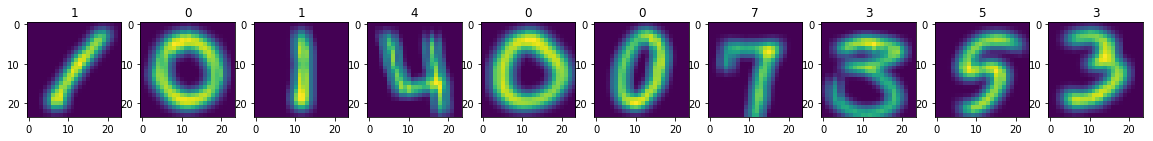

In [16]:
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    ax[i].imshow(apply_filter(train_img[i], kernel, 2))
    ax[i].set_title(int(train_label[i]))

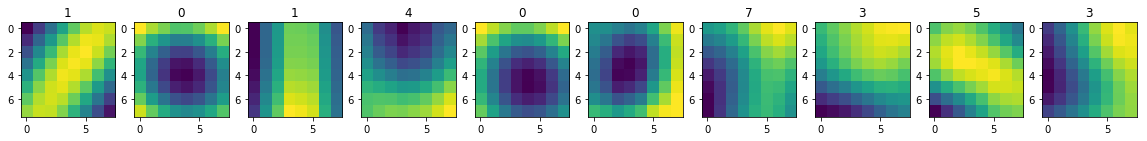

In [17]:
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    ax[i].imshow(apply_filter(train_img[i], kernel, 10))
    ax[i].set_title(int(train_label[i]))

In [28]:
# Сохраняем то, что долго считалось
# train_reduce = load_obj('train_reduce')
# test_reduce = load_obj('test_reduce')
save_obj(train_reduce, 'train_reduce')
save_obj(test_reduce, 'test_reduce')

In [18]:
# Сжимаем изображения train
train_reduce = np.zeros((train.shape[0], 64))
for i in tqdm_notebook(range(train_img.shape[0])):
    train_reduce[i] = np.reshape(apply_filter(train_img[i], kernel, 10), 64)
    
# Сжимаем изображения test
test_reduce = np.zeros((test.shape[0], 64))
for i in tqdm_notebook(range(test_img.shape[0])):
    test_reduce[i] = np.reshape(apply_filter(test_img[i], kernel, 10), 64)

HBox(children=(IntProgress(value=0, max=42000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=28000), HTML(value='')))

### PCA

In [29]:
pca = PCA(n_components=16)

In [30]:
train_pca = pca.fit_transform(train[:,1:])
test_pca = pca.fit_transform(test)

Text(0.5,1,'0')

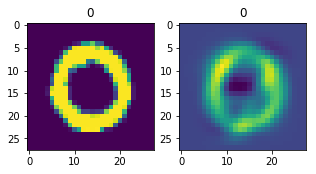

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(train_img[1])
ax[0].set_title(int(train_label[1]))
ax[1].imshow(np.resize(pca.inverse_transform(train_pca[1]), (28, 28)))
ax[1].set_title(int(train_label[1]))

### Preparing dataset

In [32]:
df_train = np.concatenate((train_hist, train_reduce, train_pca), axis=1)
df_test = np.concatenate((test_hist, test_reduce, test_pca), axis=1)

### Model

In [33]:
# Тестируем на лесе
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_train, train_label, test_size=0.4)

In [35]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
# Неплохо!
accuracy_score(forest.predict(X_test), y_test)

0.9241666666666667

In [45]:
# Реализуем на XGBoost
xgb_classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.075,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [46]:
xgb_classifier.fit(df_train, train_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.075,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [37]:
forest.fit(df_train, train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Preparing submission

In [47]:
pred  = xgb_classifier.predict(df_test)

C:\Users\astashkin.p.SLV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [48]:
pred = pred.astype(int)

In [49]:
sub = np.concatenate((np.arange(1, len(pred)+1).reshape(-1,1), pred.reshape(-1,1)), axis=1)

In [51]:
np.savetxt('./data/submission_new.csv', sub, delimiter=',', header='ImageId,Label', fmt='%d', comments='')

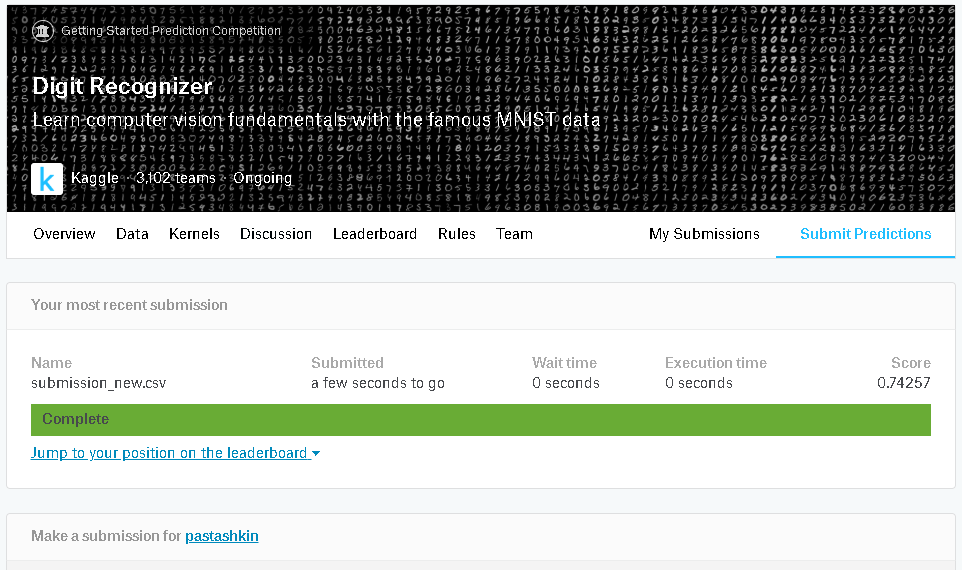

In [53]:
# Final score is 0.74257
Image('./data/score.png')